In [1]:
import os 
import timm
import torch
import torch
import torch.nn as nn
import requests
import timm
import math
from PIL import Image
from torchvision import transforms
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from lightly.data.dataset import LightlyDataset

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [2]:
from multissl.models import PasiphaeUPerNetModule, PasiphaeUPerNet
from multissl.plotting.rgb_batch import rgb_visualize_batch

In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
import pytorch_lightning as pl
from pycocotools.coco import COCO
from pycocotools import mask as mask_utils
from tqdm import tqdm

class COCOSegmentationDataset(Dataset):
    """
    Dataset for loading a COCO image with its segmentation mask
    """
    def __init__(self, coco_json_path, img_dir, transform=None, target_transform=None):
        """
        Args:
            coco_json_path: Path to COCO JSON annotations file
            img_dir: Directory with the images
            transform: Optional transform for the image
            target_transform: Optional transform for the mask
        """
        self.coco = COCO(coco_json_path)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
        # Get all image ids with segmentation annotations
        self.img_ids = list(self.coco.imgs.keys())
        
        # Filter ids to ensure each image has segmentation annotations
        self.img_ids = [img_id for img_id in self.img_ids 
                        if len(self.coco.getAnnIds(imgIds=img_id, iscrowd=None)) > 0]
        
        # Get category information
        self.categories = self.coco.loadCats(self.coco.getCatIds())
        self.category_names = {cat['id']: cat['name'] for cat in self.categories}
        self.num_classes = len(self.categories) + 1  # +1 for background
        
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, idx):
        """
        Get image and mask for a given index
        
        Args:
            idx: Index to retrieve
            
        Returns:
            dict: Contains RGB image and segmentation mask
        """
        img_id = self.img_ids[idx]
        
        # Load image information
        img_info = self.coco.loadImgs(img_id)[0]
        image_path = os.path.join(self.img_dir, img_info['file_name'])
        
        # Load RGB image
        image = Image.open(image_path).convert("RGB")
        
        # Create segmentation mask
        mask = self.create_mask(img_id, img_info['height'], img_info['width'])
        
        # Apply transforms
        if self.transform is not None:
            image = self.transform(image)
            
        if self.target_transform is not None:
            mask = self.target_transform(mask)
        else:
            # Convert mask to tensor if no transform is specified
            mask = torch.from_numpy(mask).long()
        
        return {'rgb': image, 'mask': mask, 'img_id': img_id}
    
    def create_mask(self, img_id, height, width):
        """
        Create a segmentation mask for a given image
        
        Args:
            img_id: Image ID
            height, width: Dimensions of the image
            
        Returns:
            mask: Segmentation mask where each pixel value corresponds to a class ID
        """
        # Initialize empty mask with zeros (background)
        mask = np.zeros((height, width), dtype=np.uint8)
        
        # Get annotations for this image
        ann_ids = self.coco.getAnnIds(imgIds=img_id, iscrowd=None)
        annotations = self.coco.loadAnns(ann_ids)
        
        # Sort annotations by area (to handle overlapping masks)
        annotations = sorted(annotations, key=lambda x: x['area'], reverse=True)
        
        # Add each annotation to the mask
        for ann in annotations:
            # Convert COCO format to binary mask
            binary_mask = self.coco.annToMask(ann)
            
            # Set pixels in the binary mask to corresponding category ID
            # Add 1 to category ID because 0 is reserved for background
            mask[binary_mask == 1] = ann['category_id']
        
        return mask
    
    def visualize_item(self, idx):
        """
        Visualize an image and its segmentation mask
        
        Args:
            idx: Index to visualize
            
        Returns:
            Displays the image and mask
        """
        item = self[idx]
        image = item['rgb']
        mask = item['mask']
        img_id = item['img_id']
        
        # Convert tensor to numpy for visualization
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]
            # Normalize to [0, 1] if needed
            if image.max() > 1.0 or image.min() < 0.0:
                image = (image - image.min()) / (image.max() - image.min())
        
        if isinstance(mask, torch.Tensor):
            mask = mask.numpy()
        
        # Create a color map for the mask
        # This is a simple color map where each class gets a different color
        cmap = plt.cm.get_cmap('tab20', self.num_classes)
        colored_mask = cmap(mask)
        
        # Plot the image and mask
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # Plot image
        axes[0].imshow(image)
        axes[0].set_title(f'Image (ID: {img_id})')
        axes[0].axis('off')
        
        # Plot mask
        axes[1].imshow(colored_mask)
        axes[1].set_title('Segmentation Mask')
        axes[1].axis('off')
        
        # Add annotation for each class in the mask
        unique_classes = np.unique(mask)
        legend_elements = []
        for cls in unique_classes:
            if cls == 0:
                name = 'Background'
            else:
                name = self.category_names.get(cls, f'Class {cls}')
            legend_elements.append(plt.Rectangle((0, 0), 1, 1, color=cmap(cls), label=name))
        
        axes[1].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1))
        
        plt.tight_layout()
        plt.show()


def create_transforms(target_size=(224, 224)):
    """
    Create transforms for image and mask
    
    Args:
        target_size: Target size for resizing
        
    Returns:
        transform: Transform for images
        target_transform: Transform for masks
    """
    # Image transforms
    transform = transforms.Compose([
        transforms.Resize(target_size, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.ToTensor(),
    ])
    
    # Mask transforms
    target_transform = transforms.Compose([
        transforms.Lambda(lambda x: Image.fromarray(x) if isinstance(x, np.ndarray) else x),
        transforms.Resize(target_size, interpolation=transforms.InterpolationMode.NEAREST),
        transforms.Lambda(lambda x: torch.from_numpy(np.array(x)).long()),
    ])
    
    return transform, target_transform
import torch
import numpy as np
import random
from torch.utils.data import Sampler, Dataset, DataLoader
from typing import List, Dict, Tuple, Any, Optional, Callable, Union
import torchvision.transforms.functional as TF
from PIL import Image

class ImageDuplicateSampler(Sampler):
    """
    Sampler that duplicates a single image multiple times for training.
    Useful for training on a single image by artificially expanding the dataset.
    """
    def __init__(self, dataset_size: int, batch_size: int, num_duplicates: int = 10):
        """
        Args:
            dataset_size: Size of the dataset (should be 1 for single image dataset)
            batch_size: Batch size for training
            num_duplicates: Number of times to duplicate the image in each batch
        """
        self.dataset_size = dataset_size
        self.batch_size = batch_size
        self.num_duplicates = num_duplicates
        self.total_size = self.dataset_size * self.num_duplicates
        
    def __iter__(self):
        # Always return index 0 (for a single image dataset)
        # Repeat it num_duplicates times
        indices = [0] * self.num_duplicates
        return iter(indices)
    
    def __len__(self):
        return self.total_size


def single_image_collate_fn(batch: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
    """
    Collate function that applies different augmentations to the same image
    to create a batch of varied versions of the same image.
    
    Args:
        batch: List of batch items, each item is a dict with 'rgb' and 'mask'
        
    Returns:
        Collated batch with augmented versions of the same image and mask
    """
    # Since we're duplicating a single image, batch should contain identical items
    # We just need to apply different augmentations to each copy
    
    # Get the single item (should be the same for all batch items)
    rgb = batch[0]['rgb']  # Shape: [C, H, W]
    mask = batch[0]['mask']  # Shape: [H, W]
    
    # Convert tensors to PIL images for easier augmentation
    rgb_pil = TF.to_pil_image(rgb)
    mask_pil = TF.to_pil_image(mask.unsqueeze(0).float()/255)
    
    # Create empty lists to store augmented versions
    augmented_rgb_list = []
    augmented_mask_list = []
    
    # Apply different augmentations to create a batch
    for _ in range(len(batch)):
        # Decide random augmentations for this version
        # All augmentations must be applied identically to both rgb and mask
        
        # Random horizontal flip (50% chance)
        if random.random() > 0.5:
            rgb_aug = TF.hflip(rgb_pil)
            mask_aug = TF.hflip(mask_pil)
        else:
            rgb_aug = rgb_pil
            mask_aug = mask_pil
        
        # Random vertical flip (25% chance)
        if random.random() > 0.75:
            rgb_aug = TF.vflip(rgb_aug)
            mask_aug = TF.vflip(mask_aug)
        
        # Random rotation (0, 90, 180, or 270 degrees)
        if random.random() > 0.5:
            angle = random.choice([90, 180, 270])
            rgb_aug = TF.rotate(rgb_aug, angle)
            mask_aug = TF.rotate(mask_aug, angle)
        
        # Random brightness, contrast, and saturation (only for RGB image)
        if random.random() > 0.5:
            brightness_factor = random.uniform(0.8, 1.2)
            contrast_factor = random.uniform(0.8, 1.2)
            saturation_factor = random.uniform(0.8, 1.2)
            
            rgb_aug = TF.adjust_brightness(rgb_aug, brightness_factor)
            rgb_aug = TF.adjust_contrast(rgb_aug, contrast_factor)
            rgb_aug = TF.adjust_saturation(rgb_aug, saturation_factor)
        
        # Convert back to tensors
        rgb_tensor = TF.to_tensor(rgb_aug)
        
        # Convert mask back to tensor and ensure it's in the correct format
        mask_tensor = torch.from_numpy(np.array(mask_aug).astype(np.uint8)).squeeze().long()
        
        # Add to lists
        augmented_rgb_list.append(rgb_tensor)
        augmented_mask_list.append(mask_tensor)
    
    # Stack tensors to create batches
    rgb_batch = torch.stack(augmented_rgb_list)
    mask_batch = torch.stack(augmented_mask_list)
    
    return {'rgb': rgb_batch, 'mask': mask_batch}


# Segmentation Head Loading

In [4]:

args = {"checkpoint_path":"../checkpoints_smote_16h/last-v1.ckpt",
"num_classes": 2,
"freeze_backbone": True,
       "batch_size": 4,
       }


cfg = {'img_size': 720,
        'patch_size': 16,
        'embed_dim': 192,
        'depth': 12,
        'num_heads': 3,
        'mlp_ratio': 4.0,
        'qkv_bias': True,
        'use_channel_embeds': True,
            }


# Load model as opytorchlighnting Module
pl_model = PasiphaeUPerNetModule(
        num_classes=args["num_classes"],
        checkpoint_path=args["checkpoint_path"],
        freeze_backbone=args["freeze_backbone"],
        backbone_cfg = cfg
        )


Loading checkpoint from ../checkpoints_smote_16h/last-v1.ckpt
Unexpected keys: ['projection_head.layers.0.weight', 'projection_head.layers.1.weight', 'projection_head.layers.1.bias', 'projection_head.layers.1.running_mean', 'projection_head.layers.1.running_var', 'projection_head.layers.1.num_batches_tracked', 'projection_head.layers.3.weight', 'projection_head.layers.4.weight', 'projection_head.layers.4.bias', 'projection_head.layers.4.running_mean', 'projection_head.layers.4.running_var', 'projection_head.layers.4.num_batches_tracked', 'projection_head.layers.6.weight', 'projection_head.layers.7.running_mean', 'projection_head.layers.7.running_var', 'projection_head.layers.7.num_batches_tracked', 'prediction_head.layers.0.weight', 'prediction_head.layers.1.weight', 'prediction_head.layers.1.bias', 'prediction_head.layers.1.running_mean', 'prediction_head.layers.1.running_var', 'prediction_head.layers.1.num_batches_tracked', 'prediction_head.layers.3.weight', 'prediction_head.layers.3

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Visualizing the dataset:


C:\Users\judoj\AppData\Local\Temp\ipykernel_896\520719030.py:142: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', self.num_classes)


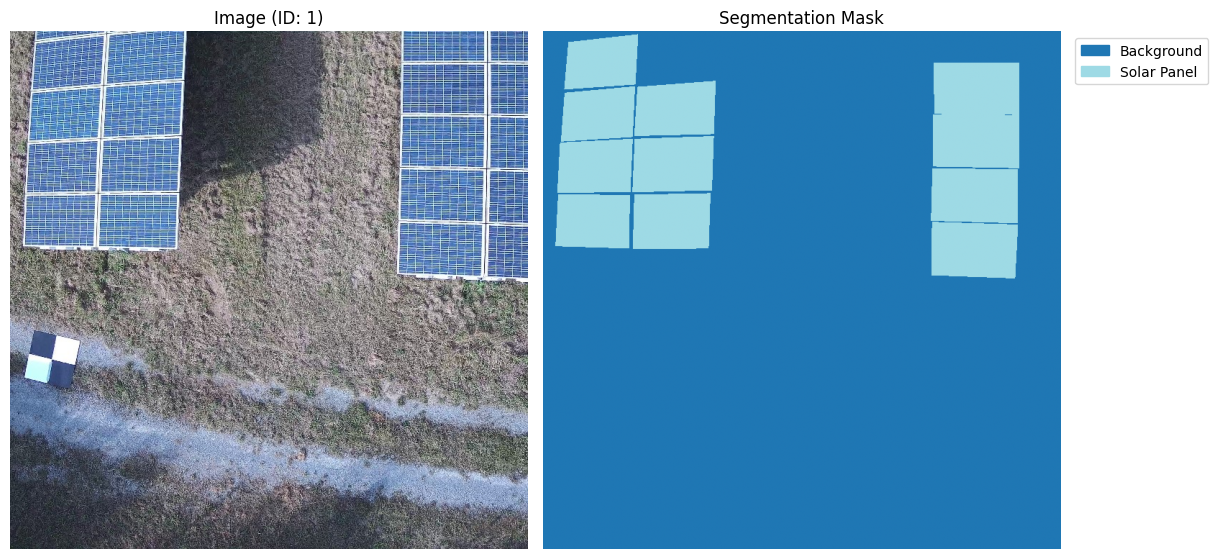

In [5]:
transform, target_transform = create_transforms(target_size=cfg["img_size"])

image_path = "../dataset/solarcoco/imgs"
mask_path = "../dataset/solarcoco/annotations/frame_000003.JSON"


# Create dataset
dataset = COCOSegmentationDataset(
   coco_json_path = mask_path,
    img_dir = image_path, 
    transform=transform, 
    target_transform=target_transform
)



# Visualize the dataset
print("Visualizing the dataset:")
dataset.visualize_item(0)


sampler = ImageDuplicateSampler(
        dataset_size=1,
        batch_size=args["batch_size"],
        num_duplicates=args["batch_size"]
    )


# Create dataloader
dataloader = DataLoader(
    dataset, 
    batch_size=args["batch_size"], 
    sampler = sampler,
    collate_fn = single_image_collate_fn,
    num_workers=0  # Use 0 for single image to avoid overhead
)



In [6]:
# Create progress bar callback
from pytorch_lightning.callbacks import RichProgressBar
class LossProgressBar(RichProgressBar):
    def __init__(self):
        super().__init__()
        self.losses = []
        
    def on_train_epoch_end(self, trainer, pl_module):
        super().on_train_epoch_end(trainer, pl_module)
        loss = float(trainer.callback_metrics.get('train_loss', 0))
        self.losses.append(loss)
        
progress_bar = LossProgressBar()

# Create model checkpoint callback
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='train_loss',
    filename='pasiphae-upernet-{epoch:02d}-{train_loss:.4f}',
    save_top_k=1,
    mode='min'
)

# Early stopping callback
early_stop_callback = pl.callbacks.EarlyStopping(
    monitor='train_loss',
    patience=10,
    mode='min'
)

# Create trainer
trainer = pl.Trainer(
    max_epochs=50,
    devices=1,
    callbacks=[progress_bar, checkpoint_callback, early_stop_callback],
    logger=True,
    log_every_n_steps=1,
    accelerator = "cuda"
)

# Train model
print("Starting training...")
trainer.fit(pl_model, dataloader)

print("Training complete!")




GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting training...


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ PasiphaeUPerNet  │ 11.5 M │ train │
│ 1 │ criterion │ CrossEntropyLoss │      0 │ train │
└───┴───────────┴──────────────────┴────────┴───────┘

Trainable params: 5.8 M                                                                                            
Non-trainable params: 5.7 M                                                                                        
Total params: 11.5 M                                                                                               
Total estimated model params size (MB): 45                                                                         
Modules in train mode: 283                                                                                         
Modules in eval mode: 0

Output()

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training complete!


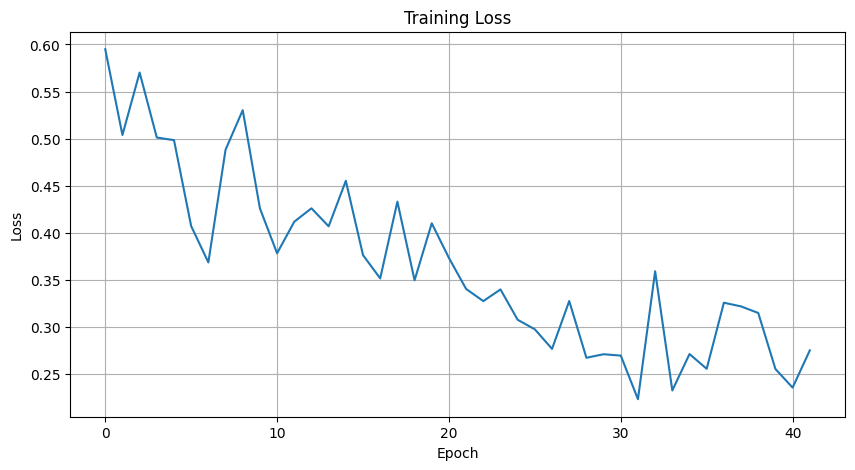

In [7]:
# Plot loss curve
losses = progress_bar.losses
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [8]:
# Save model
model = PasiphaeUPerNet(backbone_cfg=cfg, num_classes = args["num_classes"])
# Update the original model with trained weights
model.load_state_dict(pl_model.model.state_dict())



Actual feature dimensions: [576, 576, 576, 576, 576, 576]


<All keys matched successfully>

In [9]:
# Apply to dataset:
# Create train/val/test datasets
rgb_transform = transforms.Compose([
    transforms.Resize((720,720), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
])


solar_folder = "../dataset/pvhawk" 

non_labeled = LightlyDataset(input_dir = "../dataset/pvhawk",transform=rgb_transform)
non_labeled = torch.utils.data.DataLoader(non_labeled)

In [11]:
# Process all images
num_samples=10
device='cuda'
model.to(device)
all_results = []

model.eval()

for img, idx, img_name in iter(non_labeled):
    img = img.to(device)
    
    with torch.no_grad():
        output = model(rgb  = img)
        
    # Get predicted segmentation mask
    pred_mask = torch.argmax(output, dim=1).cpu().numpy()
    
    # Convert tensor back to PIL image for visualization
    orig_img = img.cpu().squeeze(0)
    # Denormalize
    orig_img = torch.clamp(orig_img, 0, 1)
    
    # Store results
    all_results.append({
        'image': orig_img.permute(1, 2, 0).numpy(),
        'mask': pred_mask[0],
        'filename': img_name[0]
    })
    

# Sample random images
if len(all_results) > num_samples:
    random_samples = random.sample(all_results, num_samples)
else:
    random_samples = all_results
    



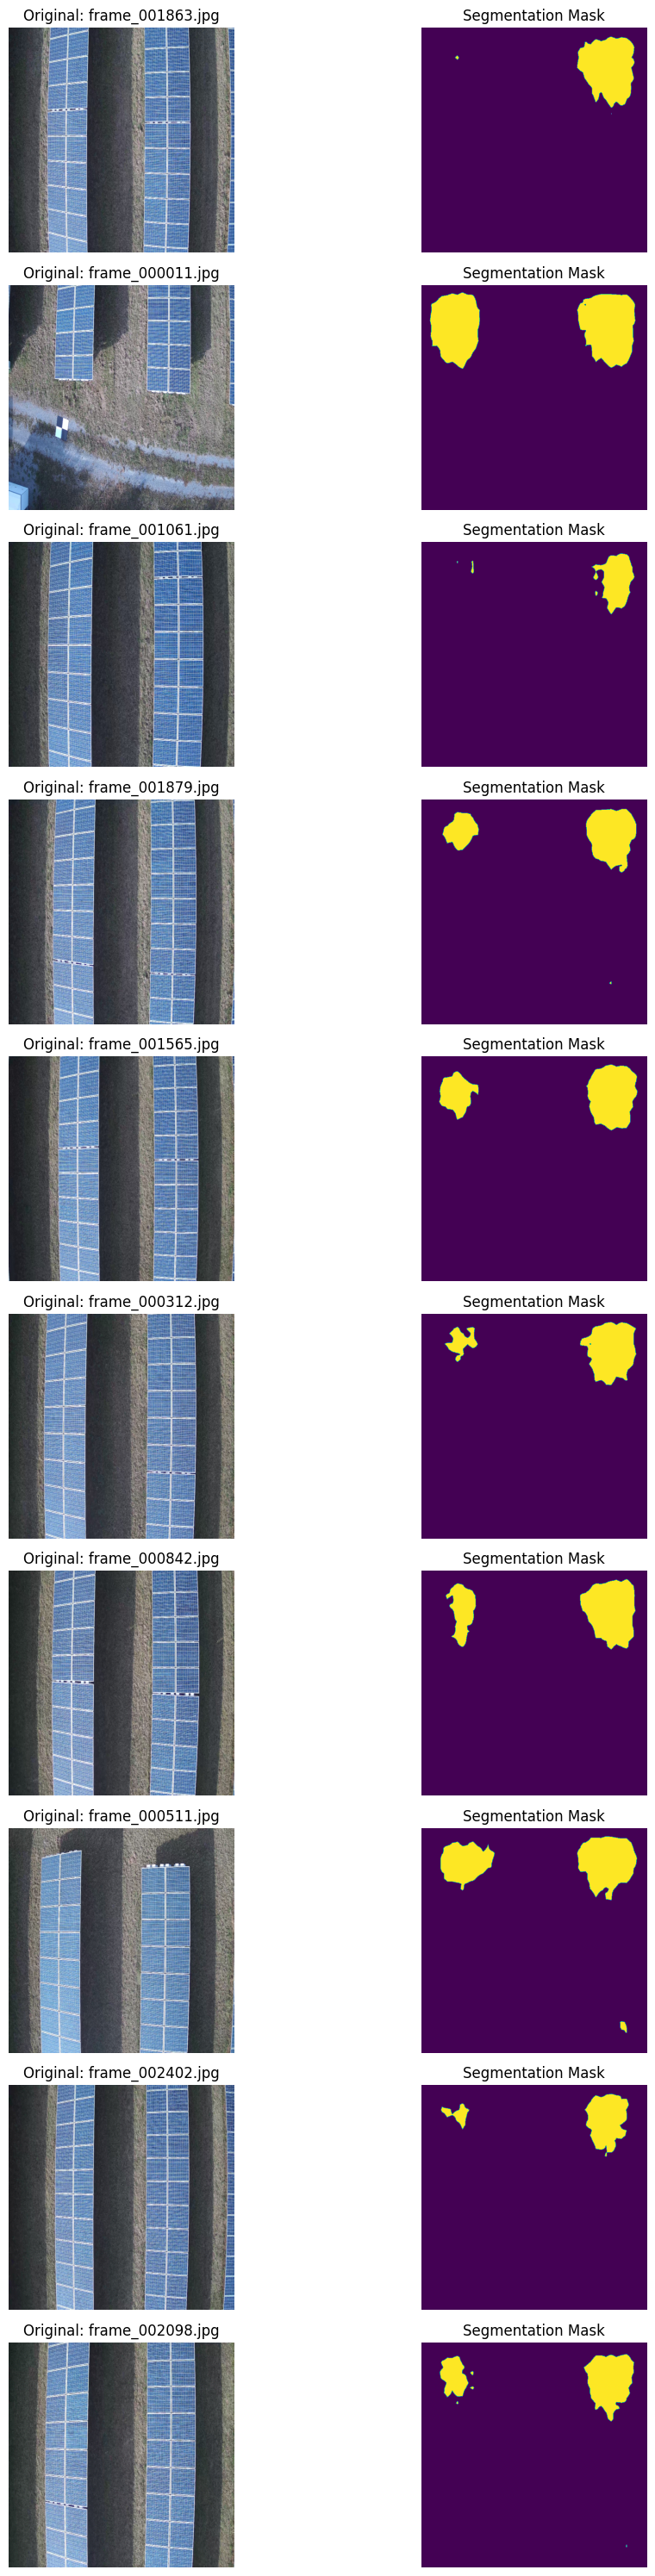

In [12]:
# Visualize the results
def visualize_segmentation(samples):
    fig, axes = plt.subplots(len(samples), 2, figsize=(12, 3*len(samples)))
    
    # If only one sample, wrap axes in a list
    if len(samples) == 1:
        axes = [axes]
    
    for i, sample in enumerate(samples):
        # Original image
        axes[i][0].imshow(sample['image'])
        axes[i][0].set_title(f"Original: {sample['filename']}")
        axes[i][0].axis('off')
        
        # Segmentation mask - using a colormap to make it more visible
        axes[i][1].imshow(sample['mask'], cmap='viridis')
        axes[i][1].set_title(f"Segmentation Mask")
        axes[i][1].axis('off')
    
    plt.tight_layout()
    plt.savefig('segmentation_results.png', dpi=300, bbox_inches='tight')
    plt.show()


visualize_segmentation(random_samples)

In [ ]:


output_path = "model_trained_on_single_image.pth"
torch.save(model.state_dict(), output_path)
print(f"Model saved to {output_path}")
